In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()
import collections
import pathlib
import re
import string
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt
import tensorflow_text as tf_text
from tensorflow import keras

In [2]:
tfds.disable_progress_bar()


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
#batch_size = 32
seed = 42

train_dataset = preprocessing.text_dataset_from_directory(
    'bbc',
#    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 2225 files belonging to 5 classes.
Using 1780 files for training.


In [4]:
test_dataset = preprocessing.text_dataset_from_directory(
    'bbc',
#    batch_size=batch_size,
    validation_split=.2,
    subset='validation',
    seed=seed)

Found 2225 files belonging to 5 classes.
Using 445 files for validation.


In [5]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [6]:
vocab = np.array(encoder.get_vocabulary())


In [7]:
model = tf.keras.Sequential([
    encoder,  
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [8]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [9]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint ('/tmp/checkpoint', save_best_only=True)
# tf.keras.callbacks.ModelCheckpoint
earlystopping_cb = keras.callbacks.EarlyStopping (patience=10, restore_best_weights=True)

In [10]:
history = model.fit(train_dataset, epochs=50,
                    validation_data=test_dataset, 
                    validation_steps=10,
                    callbacks=earlystopping_cb)

Epoch 1/50
56/56 [==============================] - 51s 911ms/step - loss: 1.5731 - accuracy: 0.3270 - val_loss: 1.4523 - val_accuracy: 0.4344
Epoch 2/50
56/56 [==============================] - 39s 700ms/step - loss: 0.8125 - accuracy: 0.7365 - val_loss: 0.5138 - val_accuracy: 0.8687
Epoch 3/50
56/56 [==============================] - 36s 650ms/step - loss: 0.1846 - accuracy: 0.9590 - val_loss: 0.2241 - val_accuracy: 0.9312
Epoch 4/50
56/56 [==============================] - 34s 602ms/step - loss: 0.0669 - accuracy: 0.9854 - val_loss: 0.1636 - val_accuracy: 0.9594
Epoch 5/50
56/56 [==============================] - 35s 631ms/step - loss: 0.0610 - accuracy: 0.9882 - val_loss: 0.1899 - val_accuracy: 0.9438
Epoch 6/50
56/56 [==============================] - 35s 620ms/step - loss: 0.0248 - accuracy: 0.9938 - val_loss: 0.2119 - val_accuracy: 0.9344
Epoch 7/50
56/56 [==============================] - 32s 563ms/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.2424 - val_accuracy: 0.9375

In [11]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

14/14 [==============================] - 1s 83ms/step - loss: 0.2272 - accuracy: 0.9573
Test Loss: 0.22723928093910217
Test Accuracy: 0.9573033452033997


(0.0, 1.6517485362594015)

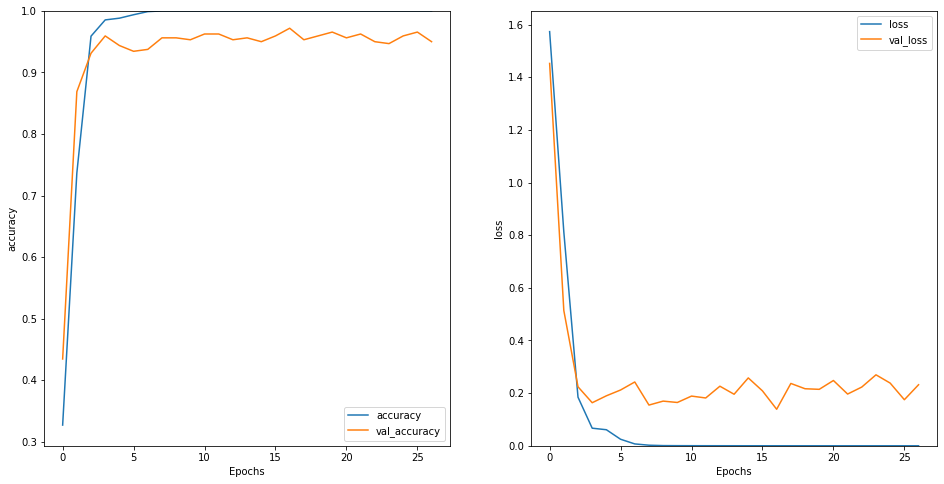

In [12]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [13]:
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(5)
# ])